# Implementación de Agente RL para NBA

Este notebook implementa un agente de Reinforcement Learning para el sistema NBA usando:
1. Multi-Armed Bandits para aprendizaje por segmento
2. Comparación con baseline aleatorio

## 1. Cargar y Preparar los Datos

In [1]:
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# Configurar semilla para reproducibilidad
np.random.seed(42)

In [2]:
# Cargar datos
df_clientes = pd.read_csv('datos_sinteticos/clientes.csv')
df_productos = pd.read_csv('datos_sinteticos/productos.csv')
df_interacciones = pd.read_csv('datos_sinteticos/interacciones.csv')

# Crear codificadores para estados y acciones
le_segmentos = LabelEncoder()
le_productos = LabelEncoder()

# Codificar segmentos y productos
df_clientes['segmento_id'] = le_segmentos.fit_transform(df_clientes['segmento'])
df_productos['producto_id'] = le_productos.fit_transform(df_productos['id_producto'])

print("Datos cargados y preparados exitosamente")

Datos cargados y preparados exitosamente


## 2. Implementación del Agente Multi-Armed Bandit

In [3]:
class BanditNBA:
    def __init__(self, n_productos: int, n_segmentos: int, epsilon: float = 0.1):
        self.n_productos = n_productos
        self.n_segmentos = n_segmentos
        self.epsilon = epsilon
        
        # Inicializar Q-values para cada segmento-producto
        self.Q = np.zeros((n_segmentos, n_productos))  # Valor esperado
        self.N = np.zeros((n_segmentos, n_productos))  # Número de veces seleccionado
        
    def seleccionar_accion(self, segmento: int) -> int:
        """Seleccionar producto usando política epsilon-greedy"""
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_productos)
        return np.argmax(self.Q[segmento])
    
    def actualizar(self, segmento: int, producto: int, recompensa: float):
        """Actualizar Q-values basado en la recompensa recibida"""
        self.N[segmento, producto] += 1
        n = self.N[segmento, producto]
        self.Q[segmento, producto] += (1/n) * (recompensa - self.Q[segmento, producto])

class BaselineAleatorio:
    def __init__(self, n_productos: int):
        self.n_productos = n_productos
    
    def seleccionar_accion(self, segmento: int) -> int:
        return np.random.randint(self.n_productos)

def calcular_recompensa(aceptado: bool, margen: float) -> float:
    """Calcular recompensa basada en aceptación y margen"""
    return margen if aceptado else 0.0

## 3. Entrenamiento y Evaluación

In [4]:
def ejecutar_simulacion(agente, df_clientes, df_productos, n_episodios: int = 1000) -> List[float]:
    recompensas_acumuladas = []
    recompensa_total = 0
    
    for episodio in range(n_episodios):
        # Seleccionar cliente aleatorio
        cliente = df_clientes.sample(1).iloc[0]
        segmento_id = cliente['segmento_id']
        
        # Seleccionar producto usando el agente
        producto_id = agente.seleccionar_accion(segmento_id)
        producto = df_productos.iloc[producto_id]
        
        # Simular resultado (usando probabilidades basadas en segmento)
        prob_base = {'Premium': 0.7, 'Classic': 0.5, 'Basic': 0.3}[cliente['segmento']]
        prob_ajustada = prob_base * (1 - producto['margen_esperado'])
        aceptado = np.random.random() < prob_ajustada
        
        # Calcular recompensa
        recompensa = calcular_recompensa(aceptado, producto['margen_esperado'])
        recompensa_total += recompensa
        
        # Actualizar agente si no es baseline
        if hasattr(agente, 'actualizar'):
            agente.actualizar(segmento_id, producto_id, recompensa)
        
        recompensas_acumuladas.append(recompensa_total / (episodio + 1))
    
    return recompensas_acumuladas

# Crear y entrenar agentes
n_productos = len(df_productos)
n_segmentos = len(df_clientes['segmento'].unique())

agente_bandit = BanditNBA(n_productos, n_segmentos)
baseline = BaselineAleatorio(n_productos)

# Ejecutar simulaciones
recompensas_bandit = ejecutar_simulacion(agente_bandit, df_clientes, df_productos)
recompensas_baseline = ejecutar_simulacion(baseline, df_clientes, df_productos)

## 4. Visualización de Resultados

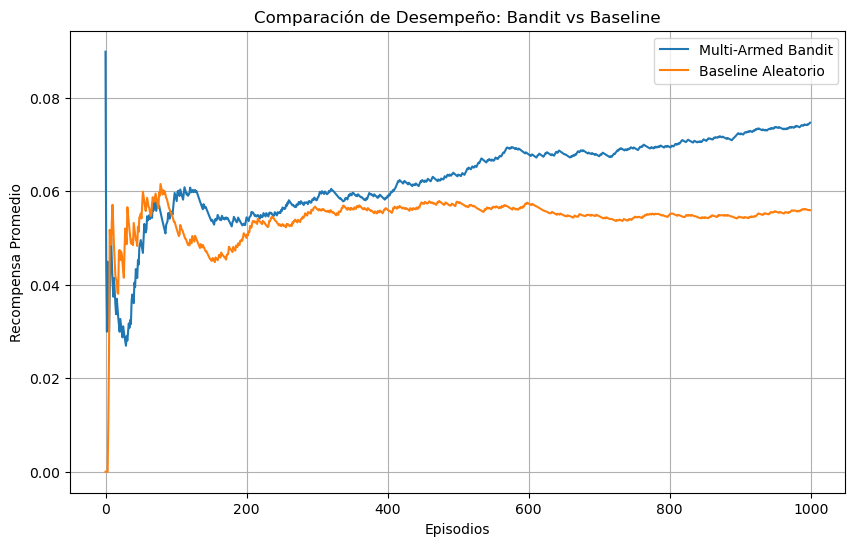

Recompensa final Bandit: 0.0746
Recompensa final Baseline: 0.0559
Mejora porcentual: 33.46%


In [5]:
plt.figure(figsize=(10, 6))
plt.plot(recompensas_bandit, label='Multi-Armed Bandit')
plt.plot(recompensas_baseline, label='Baseline Aleatorio')
plt.xlabel('Episodios')
plt.ylabel('Recompensa Promedio')
plt.title('Comparación de Desempeño: Bandit vs Baseline')
plt.legend()
plt.grid(True)
plt.show()

# Imprimir métricas finales
print(f"Recompensa final Bandit: {recompensas_bandit[-1]:.4f}")
print(f"Recompensa final Baseline: {recompensas_baseline[-1]:.4f}")
print(f"Mejora porcentual: {((recompensas_bandit[-1] / recompensas_baseline[-1]) - 1) * 100:.2f}%")

## 5. Análisis de Políticas Aprendidas

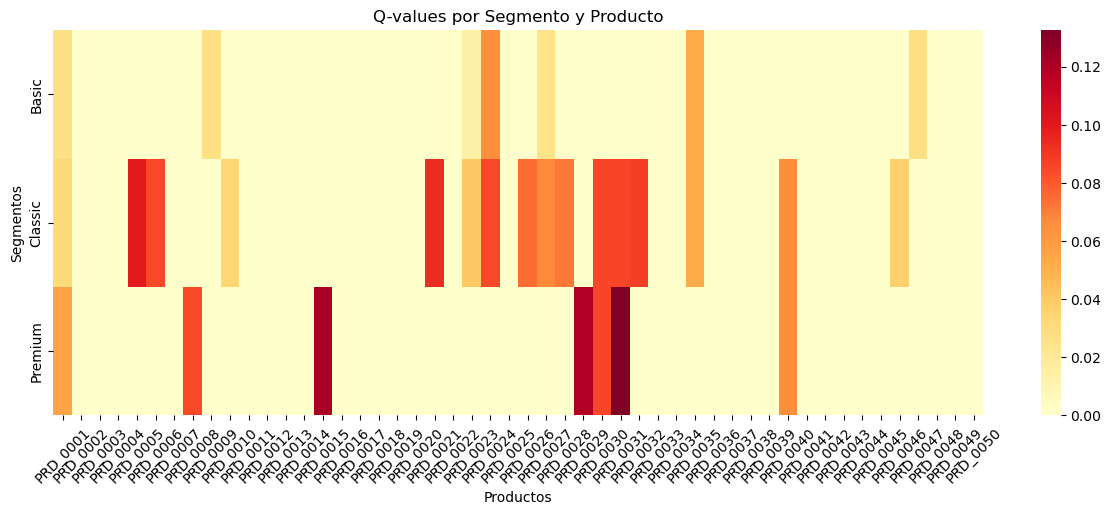


Top 3 productos para segmento Basic:
  - PRD_0024: 0.0656
  - PRD_0035: 0.0526
  - PRD_0009: 0.0269

Top 3 productos para segmento Classic:
  - PRD_0005: 0.0992
  - PRD_0021: 0.0934
  - PRD_0032: 0.0876

Top 3 productos para segmento Premium:
  - PRD_0031: 0.1326
  - PRD_0015: 0.1214
  - PRD_0029: 0.1195


In [6]:
# Visualizar Q-values para cada segmento
plt.figure(figsize=(15, 5))
sns.heatmap(agente_bandit.Q, 
            xticklabels=le_productos.inverse_transform(range(n_productos)),
            yticklabels=le_segmentos.inverse_transform(range(n_segmentos)),
            cmap='YlOrRd')
plt.title('Q-values por Segmento y Producto')
plt.xlabel('Productos')
plt.ylabel('Segmentos')
plt.xticks(rotation=45)
plt.show()

# Mostrar top 3 productos por segmento
for segmento_id in range(n_segmentos):
    segmento = le_segmentos.inverse_transform([segmento_id])[0]
    top_productos = np.argsort(agente_bandit.Q[segmento_id])[-3:]
    print(f"\nTop 3 productos para segmento {segmento}:")
    for producto_id in reversed(top_productos):
        producto = le_productos.inverse_transform([producto_id])[0]
        q_value = agente_bandit.Q[segmento_id, producto_id]
        print(f"  - {producto}: {q_value:.4f}")